# **House MD**
____________________________________________________________________
____________________________________________________________________
____________________________________________________________________

 Match diagnosis to real diagnosis i will create a ground truth file and match it to the diagnosis the LLM predicted

In [ ]:
!pip install -q kaggle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **Data Understanding**

In [ ]:
import kagglehub
path = kagglehub.dataset_download("bachrr/covid-chest-xray")
print("Path to dataset files:", path)

100%|██████████| 241M/241M [00:01<00:00, 135MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4


In [ ]:
metadata_path = os.path.join(path, "metadata.csv")
df = pd.read_csv(metadata_path)
print("Shape of dataframe:", df.shape)
df.head()

Shape of dataframe: (372, 29)


,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
df = df.drop(columns=[
    'Unnamed: 28', 'doi', 'url', 'license',
    'clinical_notes', 'other_notes'
], errors='ignore')

In [ ]:
df['finding'].value_counts()

,count
finding,
COVID-19,296
Streptococcus,17
SARS,16
Pneumocystis,15
"COVID-19, ARDS",12
ARDS,4
E.Coli,4
No Finding,3
Chlamydophila,2


In [ ]:
df['label'] = df['finding'].apply(lambda x: 1 if 'COVID' in str(x).upper() else 0)

In [ ]:
df[['age', 'sex', 'filename']].isnull().sum()

,0
age,54
sex,43
filename,0


### **Data Cleaning**

In [ ]:
df = df.dropna(subset=['filename'])
df['age'] = df['age'].fillna(df['age'].median())
df['sex'] = df['sex'].fillna('Unknown')

In [ ]:
df = df[df['modality'].str.lower() == 'x-ray']
df = df[df['view'].isin(['PA', 'AP'])]

In [ ]:
df = df.drop(columns=[
    'Unnamed: 28', 'doi', 'url', 'license',
    'clinical_notes', 'other_notes'
], errors='ignore')
df['label'] = df['finding'].apply(lambda x: 1 if 'COVID' in str(x).upper() else 0)
df = df.dropna(subset=['filename'])
df['age'] = df['age'].fillna(df['age'].median())
df['sex'] = df['sex'].fillna('Unknown')
df = df[df['modality'].str.lower() == 'x-ray']
df = df[df['view'].isin(['PA', 'AP'])]

In [ ]:
df['age'].fillna(df['age'].median(), inplace=True)
df['sex'].fillna('Unknown', inplace=True)

/tmp/ipython-input-1150401816.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/tmp/ipython-input-1150401816.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
df['age'] = df['age'].fillna(df['age'].median())

df['sex'] = df['sex'].fillna('Unknown')

In [ ]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
duplicates = df[df.duplicated()]

Number of duplicate rows: 0


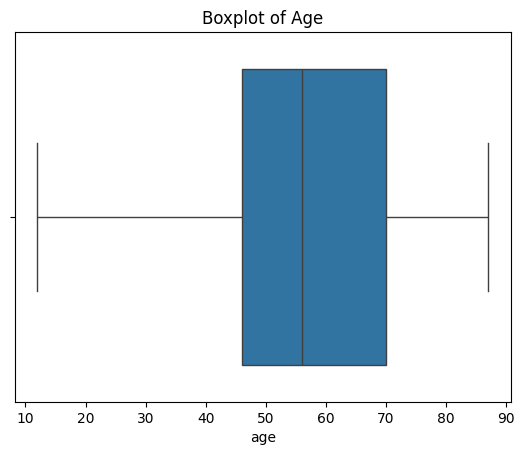

Number of outliers in 'age': 0


In [ ]:
sns.boxplot(x=df['age'])
plt.title("Boxplot of Age")
plt.show()
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['age'] < Q1 - 1.5 * IQR) | (df['age'] > Q3 + 1.5 * IQR)]
print(f"Number of outliers in 'age': {len(outliers)}")

In [ ]:
print("Unique values in 'sex':")
print(df['sex'].value_counts())

Unique values in 'sex':
sex
M          129
F           90
Unknown     34
Name: count, dtype: int64


In [ ]:
df['sex'] = df['sex'].str.strip().str.lower()
df['sex'] = df['sex'].map({
    'male': 'male',
    'm': 'male',
    'female': 'female',
    'f': 'female',
    'unknown': 'unknown'
})

In [ ]:
df['age'].fillna(df['age'].median(), inplace=True)
df['sex'].fillna('Unknown', inplace=True)
df['sex'] = df['sex'].map({'M': 'Male', 'F': 'Female', 'Unknown': 'Unknown'})

/tmp/ipython-input-4158775488.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/tmp/ipython-input-4158775488.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
df['age'] = df['age'].fillna(df['age'].median())
df['sex'] = df['sex'].fillna('Unknown')

In [ ]:
df['filename'] = df['filename'].fillna('unknown_filename')
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('Unknown')
        else:
            df[col] = df[col].fillna(df[col].median())

In [ ]:
categorical_cols = ['sex', 'finding', 'intubated', 'intubation_present', 'went_icu', 'in_icu']

for col in categorical_cols:
    print(f"Unique values in '{col}':")
    print(df[col].value_counts(dropna=False))
    print("\n")

Unique values in 'sex':
sex
Unknown    253
Name: count, dtype: int64


Unique values in 'finding':
finding
COVID-19          191
SARS               16
Streptococcus      13
Pneumocystis       12
COVID-19, ARDS     11
ARDS                4
No Finding          2
Legionella          2
Chlamydophila       1
Klebsiella          1
Name: count, dtype: int64


Unique values in 'intubated':
intubated
Unknown    200
Y           46
N            7
Name: count, dtype: int64


Unique values in 'intubation_present':
intubation_present
Unknown    202
N           26
Y           25
Name: count, dtype: int64


Unique values in 'went_icu':
went_icu
Unknown    225
Y           26
N            2
Name: count, dtype: int64


Unique values in 'in_icu':
in_icu
Unknown    250
N            3
Name: count, dtype: int64




In [ ]:
cols_with_unknown = ['sex', 'intubated', 'intubation_present', 'went_icu', 'in_icu']

for col in cols_with_unknown:
    df[col] = df[col].replace('Unknown', np.nan)

/tmp/ipython-input-94298152.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('Unknown', np.nan)


In [ ]:
print(df[cols_with_unknown].isna().sum())

sex                   253
intubated             200
intubation_present    202
went_icu              225
in_icu                250
dtype: int64


In [ ]:
for col in cols_with_unknown:
    df[col] = df[col].astype('object').replace('Unknown', np.nan)

In [ ]:
icu_cols = ['went_icu', 'in_icu', 'intubated', 'intubation_present']

for col in icu_cols:
    df[col].fillna('N', inplace=True)
df['sex'].fillna('Unknown', inplace=True)

/tmp/ipython-input-4280670109.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('N', inplace=True)
/tmp/ipython-input-4280670109.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method(

In [ ]:
missing_pct = df.isna().mean() * 100
print(missing_pct[missing_pct > 50])

Series([], dtype: float64)


In [ ]:
cols_to_drop = missing_pct[missing_pct > 50].index
df.drop(columns=cols_to_drop, inplace=True)


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['offset'] = pd.to_numeric(df['offset'], errors='coerce')

In [ ]:
df = pd.get_dummies(df, columns=['sex', 'finding', 'intubated', 'intubation_present', 'went_icu', 'in_icu'], drop_first=True)

In [ ]:
print(df.columns.tolist())

['patientid', 'offset', 'age', 'survival', 'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date', 'location', 'folder', 'filename', 'label', 'finding_COVID-19', 'finding_COVID-19, ARDS', 'finding_Chlamydophila', 'finding_Klebsiella', 'finding_Legionella', 'finding_No Finding', 'finding_Pneumocystis', 'finding_SARS', 'finding_Streptococcus', 'intubated_Y', 'intubation_present_Y', 'went_icu_Y']


In [ ]:
df.drop(columns=['folder', 'filename', 'location'], inplace=True)


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [ ]:
print(df.isna().sum())

patientid                   0
offset                      0
age                         0
survival                    0
needed_supplemental_O2      0
extubated                   0
temperature                 0
pO2_saturation              0
leukocyte_count             0
neutrophil_count            0
lymphocyte_count            0
view                        0
modality                    0
date                      217
label                       0
finding_COVID-19            0
finding_COVID-19, ARDS      0
finding_Chlamydophila       0
finding_Klebsiella          0
finding_Legionella          0
finding_No Finding          0
finding_Pneumocystis        0
finding_SARS                0
finding_Streptococcus       0
intubated_Y                 0
intubation_present_Y        0
went_icu_Y                  0
dtype: int64


In [ ]:
df = df.drop(columns=['date'])

In [ ]:
df.dtypes

,0
patientid,int64
offset,float64
age,float64
survival,object
needed_supplemental_O2,object
extubated,object
temperature,float64
pO2_saturation,float64
leukocyte_count,float64
neutrophil_count,float64


In [ ]:
numeric_columns = ['age', 'temperature', 'pO2_saturation', 'leukocyte_count',
                   'neutrophil_count', 'lymphocyte_count']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [ ]:
categorical_columns = ['view', 'modality', 'label']
df[categorical_columns] = df[categorical_columns].astype('category')

In [ ]:
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [ ]:
df_encoded.isnull().sum().sort_values(ascending=False)

,0
patientid,0
offset,0
age,0
survival,0
needed_supplemental_O2,0
extubated,0
temperature,0
pO2_saturation,0
leukocyte_count,0
neutrophil_count,0


In [ ]:
df_encoded.fillna(df_encoded.median(numeric_only=True), inplace=True)

In [ ]:
X = df_encoded.drop(columns=['label_1'])
y = df_encoded['label_1']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"{col}: {X[col].unique()}")


survival: ['Y' 'Unknown' 'N']
needed_supplemental_O2: ['Y' 'N' 'Unknown']
extubated: ['Unknown' 'N' 'Y']


In [ ]:
X = X.replace('Unknown', np.nan)
X = X.fillna(X.mode().iloc[0])

In [ ]:
X = pd.get_dummies(X)

In [ ]:
print(X.dtypes)

patientid                     int64
offset                      float64
age                         float64
temperature                 float64
pO2_saturation              float64
leukocyte_count             float64
neutrophil_count            float64
lymphocyte_count            float64
finding_COVID-19               bool
finding_COVID-19, ARDS         bool
finding_Chlamydophila          bool
finding_Klebsiella             bool
finding_Legionella             bool
finding_No Finding             bool
finding_Pneumocystis           bool
finding_SARS                   bool
finding_Streptococcus          bool
intubated_Y                    bool
intubation_present_Y           bool
went_icu_Y                     bool
view_PA                        bool
survival_N                     bool
survival_Y                     bool
needed_supplemental_O2_N       bool
needed_supplemental_O2_Y       bool
extubated_N                    bool
extubated_Y                    bool
dtype: object


In [ ]:
print(df.columns.tolist())


['patientid', 'offset', 'age', 'survival', 'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'label', 'finding_COVID-19', 'finding_COVID-19, ARDS', 'finding_Chlamydophila', 'finding_Klebsiella', 'finding_Legionella', 'finding_No Finding', 'finding_Pneumocystis', 'finding_SARS', 'finding_Streptococcus', 'intubated_Y', 'intubation_present_Y', 'went_icu_Y']


In [ ]:
y = df['survival']
y = df['survival'].map({'Y': 1, 'N': 0})
print(df['survival'].value_counts())

survival
Unknown    175
Y           58
N           20
Name: count, dtype: int64


In [ ]:
df = df[df['survival'].isin(['Y', 'N'])]
df['survival'] = df['survival'].map({'Y': 1, 'N': 0})

/tmp/ipython-input-801184915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['survival'] = df['survival'].map({'Y': 1, 'N': 0})  # binary


In [ ]:
y = df['survival']

In [ ]:
df.loc[:, 'survival'] = df['survival'].map({'Y': 1, 'N': 0})

/tmp/ipython-input-2288608839.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'survival'] = df['survival'].map({'Y': 1, 'N': 0})


In [ ]:
df.loc[:, 'survival'] = df['survival'].map({'Y': 1, 'N': 0}).astype('Int64')

/tmp/ipython-input-3755642210.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 78, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'survival'] = df['survival'].map({'Y': 1, 'N': 0}).astype('Int64')


In [ ]:
df['survival'] = df['survival'].map({'Y': 1, 'N': 0})
df['survival'] = df['survival'].astype('Int64')


/tmp/ipython-input-3691217704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['survival'] = df['survival'].map({'Y': 1, 'N': 0})
/tmp/ipython-input-3691217704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['survival'] = df['survival'].astype('Int64')


In [ ]:
df['survival'] = df['survival'].astype('object')
df['survival'] = df['survival'].map({'Y': 1, 'N': 0}).astype('Int64')

/tmp/ipython-input-159449802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['survival'] = df['survival'].astype('object')  # temporarily make it object dtype
/tmp/ipython-input-159449802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['survival'] = df['survival'].map({'Y': 1, 'N': 0}).astype('Int64')


In [ ]:
df.loc[:, 'survival'] = df.loc[:, 'survival'].map({'Y': 1, 'N': 0}).astype('Int64')


In [ ]:
df = df.copy()
df['survival'] = df['survival'].map({'Y': 1, 'N': 0}).astype('Int64')

In [ ]:
df.loc[:, 'survival'] = df.loc[:, 'survival'].map({'Y': 1, 'N': 0}).astype('Int64')
df.loc[:, 'age'] = df.loc[:, 'age'].fillna(df['age'].median())
df.loc[:, 'temperature'] = df.loc[:, 'temperature'].fillna(df['temperature'].median())
if 'sex' in df.columns:
    df.loc[:, 'sex'] = df.loc[:, 'sex'].fillna('Unknown')
if 'date' in df.columns:
    df.loc[:, 'date'] = pd.to_datetime(df['date'], errors='coerce')
columns_to_drop = ['Unnamed: 28', 'clinical_notes', 'other_notes']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)
if 'sex' in df.columns:
    df = pd.get_dummies(df, columns=['sex'], dummy_na=True, drop_first=True)
print(df.isnull().sum())

patientid                  0
offset                     0
age                        0
survival                  78
needed_supplemental_O2     0
extubated                  0
temperature                0
pO2_saturation             0
leukocyte_count            0
neutrophil_count           0
lymphocyte_count           0
view                       0
modality                   0
label                      0
finding_COVID-19           0
finding_COVID-19, ARDS     0
finding_Chlamydophila      0
finding_Klebsiella         0
finding_Legionella         0
finding_No Finding         0
finding_Pneumocystis       0
finding_SARS               0
finding_Streptococcus      0
intubated_Y                0
intubation_present_Y       0
went_icu_Y                 0
dtype: int64


In [ ]:
df = df.dropna(subset=['survival'])
print(f"Rows before dropping missing survival: {len(df)}")
df = df.dropna(subset=['survival'])
print(f"Rows after dropping missing survival: {len(df)}")

Rows before dropping missing survival: 0
Rows after dropping missing survival: 0


In [ ]:
print(f"Total rows in df: {len(df)}")

Total rows in df: 0


In [ ]:
print(df['survival'].isna().sum())


0


In [ ]:
print(df['survival'].notna().sum())

0


In [ ]:
df = pd.read_csv('metadata.csv')

print(df.shape)
print(df.head())

(372, 29)
   patientid  offset sex   age   finding survival intubated  \
0          2     0.0   M  65.0  COVID-19        Y       NaN   
1          2     3.0   M  65.0  COVID-19        Y       NaN   
2          2     5.0   M  65.0  COVID-19        Y       NaN   
3          2     6.0   M  65.0  COVID-19        Y       NaN   
4          4     0.0   F  52.0  COVID-19      NaN       NaN   

  intubation_present went_icu in_icu  ...              date  \
0                NaN      NaN    NaN  ...  January 22, 2020   
1                NaN      NaN    NaN  ...  January 25, 2020   
2                NaN      NaN    NaN  ...  January 27, 2020   
3                NaN      NaN    NaN  ...  January 28, 2020   
4                NaN      NaN    NaN  ...  January 25, 2020   

                                            location  folder  \
0        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
1        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
2        Cho Ray Hospital, Ho Chi Minh C

In [ ]:
df = pd.read_csv('metadata.csv')
print("Missing survival count:", df['survival'].isna().sum())
df = df.dropna(subset=['survival'])
print("Rows after dropping missing survival:", df.shape[0])
df['survival'] = df['survival'].map({'Y': 1, 'N': 0})
print(df['survival'].value_counts(dropna=False))

Missing survival count: 256
Rows after dropping missing survival: 116
survival
1    89
0    27
Name: count, dtype: int64


In [ ]:
print(df[['age', 'sex', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count']].isnull().sum())

age                   8
sex                   6
temperature         103
pO2_saturation      103
leukocyte_count     111
neutrophil_count    115
lymphocyte_count    114
dtype: int64


In [ ]:
num_cols = ['age', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
df['sex'].fillna('Unknown', inplace=True)

/tmp/ipython-input-3525087708.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3525087708.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
print(df.isnull().sum())

patientid                   0
offset                      5
sex                         0
age                         0
finding                     0
survival                    0
intubated                  90
intubation_present         84
went_icu                  101
in_icu                    109
needed_supplemental_O2    106
extubated                  94
temperature                 0
pO2_saturation              0
leukocyte_count             0
neutrophil_count            0
lymphocyte_count            0
view                        0
modality                    0
date                       21
location                   25
folder                      0
filename                    0
doi                        53
url                         0
license                    63
clinical_notes              0
other_notes                68
Unnamed: 28               114
dtype: int64


In [ ]:
clinical_cat_cols = ['intubated', 'intubation_present', 'went_icu', 'in_icu',
                    'needed_supplemental_O2', 'extubated', 'offset']
for col in clinical_cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')
cols_to_drop = ['Unnamed: 28', 'license', 'doi', 'other_notes', 'location', 'date']
for col in cols_to_drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [ ]:
print(df.isnull().sum())

patientid                 0
offset                    0
sex                       0
age                       0
finding                   0
survival                  0
intubated                 0
intubation_present        0
went_icu                  0
in_icu                    0
needed_supplemental_O2    0
extubated                 0
temperature               0
pO2_saturation            0
leukocyte_count           0
neutrophil_count          0
lymphocyte_count          0
view                      0
modality                  0
folder                    0
filename                  0
url                       0
clinical_notes            0
dtype: int64


In [ ]:
categorical_cols = ['sex', 'finding', 'intubated', 'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2', 'extubated']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
X = df_encoded.drop(columns=['survival'])
y = df_encoded['survival']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
cols_with_unknown = ['sex', 'intubated', 'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2', 'extubated']

for col in cols_with_unknown:
    df[col] = df[col].replace('Unknown', np.nan)


In [ ]:
df = df.dropna(subset=cols_with_unknown)
df[cols_with_unknown] = df[cols_with_unknown].fillna('N')
print(df[cols_with_unknown].isnull().sum())
print(df.head())

sex                       0
intubated                 0
intubation_present        0
went_icu                  0
in_icu                    0
needed_supplemental_O2    0
extubated                 0
dtype: int64
Empty DataFrame
Columns: [patientid, offset, sex, age, finding, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, folder, filename, url, clinical_notes]
Index: []

[0 rows x 23 columns]


In [ ]:
cols_with_unknown = ['sex', 'intubated', 'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2', 'extubated']

df[cols_with_unknown] = df[cols_with_unknown].fillna('N')

In [ ]:
print("Number of rows before split:", df_encoded.shape[0])
print("Target values count:")
print(y.value_counts(dropna=False))

Number of rows before split: 0
Target values count:
Series([], Name: count, dtype: int64)


In [ ]:
print("Original dataframe shape:", df.shape)
print("Missing survival count:", df['survival'].isna().sum())

Original dataframe shape: (0, 23)
Missing survival count: 0


In [ ]:
df_known_survival = df[df['survival'].notna()].copy()
print("Rows with survival:", df_known_survival.shape[0])

Rows with survival: 0


In [ ]:
df = pd.read_csv('metadata.csv')
print("Original dataframe shape:", df.shape)
print(df.head())

Original dataframe shape: (372, 29)
   patientid  offset sex   age   finding survival intubated  \
0          2     0.0   M  65.0  COVID-19        Y       NaN   
1          2     3.0   M  65.0  COVID-19        Y       NaN   
2          2     5.0   M  65.0  COVID-19        Y       NaN   
3          2     6.0   M  65.0  COVID-19        Y       NaN   
4          4     0.0   F  52.0  COVID-19      NaN       NaN   

  intubation_present went_icu in_icu  ...              date  \
0                NaN      NaN    NaN  ...  January 22, 2020   
1                NaN      NaN    NaN  ...  January 25, 2020   
2                NaN      NaN    NaN  ...  January 27, 2020   
3                NaN      NaN    NaN  ...  January 28, 2020   
4                NaN      NaN    NaN  ...  January 25, 2020   

                                            location  folder  \
0        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
1        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
2        Cho R

In [ ]:
cols_with_unknown = ['sex', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
                     'needed_supplemental_O2', 'extubated']

for col in cols_with_unknown:
    df[col] = df[col].replace('Unknown', np.nan)

In [ ]:
df = df.dropna(subset=['survival'])
df['age'] = df['age'].fillna(df['age'].median())
df['sex'] = df['sex'].fillna('Unknown')
numeric_cols = ['temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count']
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

/tmp/ipython-input-937428466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = df['age'].fillna(df['age'].median())
/tmp/ipython-input-937428466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].fillna('Unknown')
/tmp/ipython-input-937428466.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

### **Data Training**

In [ ]:
df['survival'] = df['survival'].map({'Y': 1, 'N': 0})
print(df[['survival', 'age', 'sex'] + numeric_cols].isna().sum())

survival            0
age                 0
sex                 0
temperature         0
pO2_saturation      0
leukocyte_count     0
neutrophil_count    0
lymphocyte_count    0
dtype: int64


In [ ]:
df = pd.get_dummies(df, columns=['sex'], drop_first=True)
feature_cols = ['age', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count'] + [col for col in df.columns if col.startswith('sex_')]
X = df[feature_cols]
y = df['survival']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (92, 8)
Test shape: (24, 8)


In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6666666666666666

Confusion Matrix:
 [[ 1  8]
 [ 0 15]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.65      1.00      0.79        15

    accuracy                           0.67        24
   macro avg       0.83      0.56      0.49        24
weighted avg       0.78      0.67      0.57        24



In [ ]:
print(y_train.value_counts())

survival
1    74
0    18
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train model on balanced data
clf_smote = LogisticRegression(max_iter=1000, random_state=42)
clf_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.93      0.97        15

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24

Confusion Matrix:
 [[ 9  0]
 [ 1 14]]


In [ ]:
image_folder = '/path/to/your/image/folder'

Dataset path: /root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4
Files and folders in dataset directory:
['annotations', 'images', 'metadata.csv']
Files in images folder:
['1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png', '16660_1_1.jpg', 'figure1-5e7c1b8d98c29ab001275405-98.jpeg', '16660_3_1.jpg', 'covid-19-pneumonia-progression-and-regression-day24.jpg', 'klebsiella-pneumonia-1.jpg', 'ryct.2020200034.fig2.jpeg', 'streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg', 'cavitating-pneumonia-4-day28-L.png', 'radiol.2020201160.fig3a.jpeg']


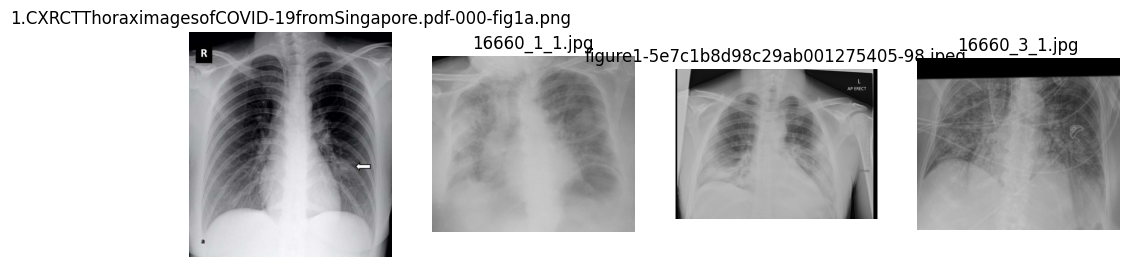

In [ ]:
print("Dataset path:", path)
print("Files and folders in dataset directory:")
print(os.listdir(path))
image_dir = os.path.join(path, "images")
print("Files in images folder:")
print(os.listdir(image_dir)[:10])
plt.figure(figsize=(12, 6))
for i, filename in enumerate(os.listdir(image_dir)[:4]):
    img_path = os.path.join(image_dir, filename)
    img = mpimg.imread(img_path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.axis('off')

plt.show()


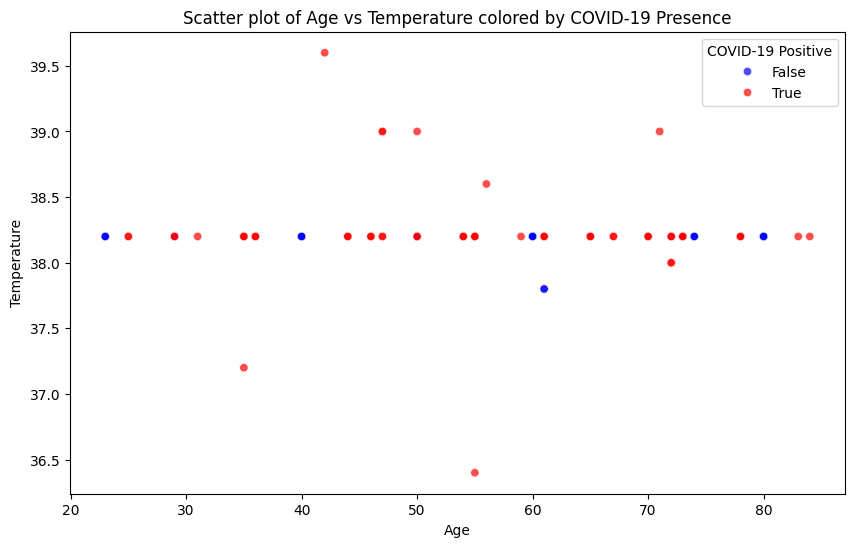

In [ ]:
df['covid_positive'] = df['finding'].str.contains('COVID-19')
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='age', y='temperature', hue='covid_positive', palette=['blue', 'red'], alpha=0.7)
plt.title('Scatter plot of Age vs Temperature colored by COVID-19 Presence')
plt.xlabel('Age')
plt.ylabel('Temperature')
plt.legend(title='COVID-19 Positive')
plt.show()